In [54]:
import torch
from torchvision import transforms, datasets
from torchvision.transforms import CenterCrop
from torch.utils.data import DataLoader, TensorDataset, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [55]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

trainset = datasets.ImageFolder(root="../../datasets/flowers/", transform=data_transform)
print("Training set consists of %d images" % (trainset.__len__()))

Training set consists of 4323 images


In [56]:
from utils.data import sampler

batch_size = 128

trainloader = DataLoader(
    dataset = trainset, 
    sampler = sampler.StratifiedSampler(data_source=trainset, n_splits=1, val_size=0.4, random_state=69, sample_train=True),
    batch_size = batch_size,
)

valloader = DataLoader(
    dataset = trainset, 
    sampler = sampler.StratifiedSampler(data_source=trainset, n_splits=1, val_size=0.4, random_state=69, sample_train=False),
    batch_size = batch_size,
)

classes_name = trainset.classes
classes_name

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [57]:
import torch.nn as nn

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

LeNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Linear(in_features=120, out_features=84),
    nn.Linear(in_features=84, out_features=10),
    )

LeNet.to(device)
print(LeNet)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Linear(in_features=84, out_features=10, bias=True)
)


In [58]:
# define loss function and optimizer

import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(LeNet.parameters(), lr=0.001, momentum=0.9)

In [59]:
# training
import numpy as np
from tqdm import tqdm

loss_history = []
rank1_accuracy_history = []
rank3_accuracy_history = []

for epoch in tqdm(range(2)):
    rank1_classes_correct = list(0. for i in range(len(classes_name)))
    rank3_classes_correct = list(0. for i in range(len(classes_name)))
    classes_total = list(0. for i in range(len(classes_name)))
    
    for i, train_data in enumerate(trainloader):
        
        # take input
        pixels, label = train_data
        
        # make sure gradient is 0
        optimizer.zero_grad()
        
        # forward pass
        pixels, label = pixels.to(device), label.to(device)
        label = label.to(device)
        prediction = LeNet(pixels)
        
        # calculate loss & record it 
        loss_score = loss_fn(prediction, label)
        
        if i == (trainloader.__len__()-1): 
            loss_history.append(loss_score)
        
        # calculate accuracy & record it
        for i, j in (torch.nonzero(torch.topk(prediction, 3)[1]  == label.view(label.size(0),-1))).tolist():
            if j == 0:
                rank1_classes_correct[label[i]] += 1
            else:
                rank3_classes_correct[label[i]] += 1
        
        for i in label:
            classes_total[i] += 1
        # backprop
        loss_score.backward()
        
        # update weight 
        optimizer.step()
    
    rank1_accuracy_per_epoch = np.sum(rank1_classes_correct) / np.sum(classes_total)
    rank1_accuracy_history.append(rank1_accuracy_per_epoch)
    rank3_accuracy_per_epoch = np.sum(rank3_classes_correct) / np.sum(classes_total)
    rank3_accuracy_history.append(rank3_accuracy_per_epoch)


100%|██████████| 2/2 [00:48<00:00, 24.83s/it]


In [60]:
for i,(j,k) in enumerate(zip(rank1_classes_correct, classes_total)):
    print("Accuracy of %s is %d%s" % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is 0%
Accuracy of dandelion is 29%
Accuracy of rose is 72%
Accuracy of sunflower is 0%
Accuracy of tulip is 0%


In [68]:
classes_total

[308.0, 421.0, 314.0, 293.0, 394.0]

In [61]:
for i,(j,k) in enumerate(zip(rank3_classes_correct, classes_total)):
    print("Accuracy of %s is %d%s" % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is 4%
Accuracy of dandelion is 49%
Accuracy of rose is 27%
Accuracy of sunflower is 76%
Accuracy of tulip is 23%


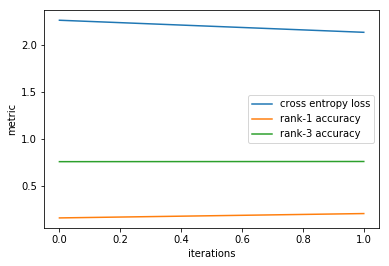

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_history, label="cross entropy loss");
plt.plot(rank1_accuracy_history, label="rank-1 accuracy")
plt.plot(rank5_accuracy_history, label="rank-3 accuracy")
plt.xlabel('iterations');
plt.ylabel('metric');
plt.legend();

In [63]:
rank1_classes_correct = list(0. for i in range(len(classes_name)))
rank3_classes_correct = list(0. for i in range(len(classes_name)))
classes_total = list(0. for i in range(len(classes_name)))
    

# validation
with torch.no_grad():
    for i, val_data in tqdm(enumerate(valloader)):
        
        # take pixels
        pixels, label = val_data
        pixels, label = pixels.to(device), label.to(device)
        
        # forward pass
        prediction = LeNet(pixels)
        
        # count accuracy
        for i, j in (torch.nonzero(torch.topk(prediction, 3)[1]  == label.view(label.size(0),-1))).tolist():
            if j == 0:
                rank1_classes_correct[label[i]] += 1
            else:
                rank3_classes_correct[label[i]] += 1
                
        for i in label:
            classes_total[i] += 1



0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
2it [00:02,  1.44s/it]
3it [00:03,  1.31s/it]
4it [00:04,  1.25s/it]
5it [00:05,  1.17s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.21s/it]
8it [00:09,  1.19s/it]
9it [00:10,  1.24s/it]
10it [00:12,  1.33s/it]
11it [00:13,  1.31s/it]
12it [00:14,  1.25s/it]
13it [00:15,  1.18s/it]
14it [00:16,  1.01it/s]


In [64]:
for i,(j,k) in enumerate(zip(rank1_classes_correct, class_total)):
    print("Accuracy of %s is: %d%s"  % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is: 0%
Accuracy of dandelion is: 20%
Accuracy of rose is: 1%
Accuracy of sunflower is: 0%
Accuracy of tulip is: 0%


In [65]:
for i,(j,k) in enumerate(zip(rank3_classes_correct, class_total)):
    print("Accuracy of %s is: %d%s"  % (classes_name[i], j/k*100, "%"))

Accuracy of daisy is: 0%
Accuracy of dandelion is: 1%
Accuracy of rose is: 20%
Accuracy of sunflower is: 1%
Accuracy of tulip is: 19%
